<a href="https://colab.research.google.com/github/KacperKaszuba0608/genotype-analysis/blob/main/VDR_genotype_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WSTĘP


Gen receptora witaminy D (VDR) odgrywa kluczową rolę w regulacji wielu
procesów fizjologicznych, w tym homeostazy wapnia, funkcji odpornościowych i różnicowania komórek [[1]](https://phmd.pl/resources/html/article/details?id=152552&language=pl).

Dwa powszechne polimorfizmy w genie VDR, FokI i BsmI, zostały szeroko zbadane ze względu na ich potencjalny wpływ na funkcjonalność VDR i późniejsze konsekwencje zdrowotne [[2]](https://www.termedia.pl/-Wplyw-polimorfizmow-genu-VDR-na-otylosc-zmiany-metaboliczne-zaburzenia-masy-kostnej-i-procesy-nowotworowe-,138,36649,0,1.html). Wykazano między innymi, że polimorfizmy genów FokI C>T i BsmI G>A genu VDR mają istotną zależność w związku z podatnością na czerniaka [[3]](https://www.researchgate.net/publication/334263920_Association_of_vitamin_D_receptor_gene_FokI_CT_BsmI_GA_TaqI_TC_EcoRV_AG_ApaI_GT_and_Cdx2_GA_polymorphisms_with_risk_of_cutaneous_melanoma_a_meta-analysis_based_on_40_case-control_studies).

Dlatego też analiza częstości występowania alleli ulegających polimorfizmom FokI i BsmI w genie VDR może pomóc w głębszym poznaniu szansy wystąpienia danego wariantu co było głównym celem niniejszej pracy.

W trakcie analizy podjęto decyzję o sprawdzeniu kilku hipotez:
1. Rozkład alleli w subpopulacjach `Cancer` i `Control` są zgodne z prawem Hardy'ego-Weinberga.
2. Brak istotnych statystycznie różnic w częstościach występowania poszczególnych genotypów w grupie `Cancer` i `Control`
3. Allel G częściej występuję niż allel A w wariancie typu FokI.
4. Allel C częściej występuje niż allel T w wariancie typu BsmI.

# ZBIÓR DANYCH I METODOLOGIA

## Importowanie Bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import chi2

## Upload Pliku z Danymi

In [2]:
from google.colab import files
file_up = files.upload()

Saving dane_projekt.xls to dane_projekt (1).xls


## Definiowanie Potrzebnych Klas i Funkcji

### Prawo Hardy'ego-Weinberg'a

In [3]:
class HardyWeinbergLaw:
  def __init__(self,df):
    '''input:
      - df: data frame containing the number of zygotes
    '''

    # Data format check (3 rows only)
    if df.shape[0] == 3:
      # Calculate the necessary variables for the Hardy-Weinberg law
      self.n = df.sum()
      self.d = df.iloc[0]
      self.h = df.iloc[1]
      self.r = df.iloc[2]
    else:
      self.n = df.sum()
      self.d = df.iloc[0]
      self.h = df.iloc[1] + df.iloc[2]
      self.r = df.iloc[-1]

  def freq(self):
    self.p = float((self.d + self.h/2) / self.n)
    self.q = 1 - self.p
    return {'p':self.p, 'q':self.q}

  def data(self):
    p, q = self.freq()
    # Calculate theoretical values of zygotes
    self.de = self.n * self.p**2
    self.he = (2*self.p*self.q) * self.n
    self.re = self.n * self.q**2

    # Create an eye-friendly format of the empirical and theoretical values
    self.teo_vs_emp = pd.DataFrame({'emp':[self.d,self.h,self.r], 'teo':[self.de,self.he,self.re]},
                                   index=['de', 'he', 're'])

    return self.teo_vs_emp

  def chi2_statistic(self,alpha=0.05):
    '''input:
        - alpha: significance level for the Chi2 test (default: alpha=0.05)
    ouptut:
        - data frame with results
    '''
    p, q = self.freq()
    teo_vs_emp = self.data()
    # Calculate values for Chi2 statistic
    teo_vs_emp['value_to_chi2'] = (teo_vs_emp['emp'] - teo_vs_emp['teo'])**2 / teo_vs_emp['teo']

    # Calculate Chi2 statistic
    statchisq = teo_vs_emp['value_to_chi2'].sum()

    # Calculate quantile from Chi2 distribution
    qchisq = chi2.ppf(1-alpha,2)

    # Making a decision about a hypothesis
    decision = 'H0 rejected' if statchisq > qchisq else 'H0 not rejected'

    # Calculate pvalue for Chi2 statistic
    pvalue = 1 - chi2.cdf(statchisq, 1)

    # Create an eye-friendly format of the Chi2 test
    self.chi2_stat = pd.DataFrame({'statistic':statchisq, 'quantile':qchisq,
                                    'p.value': pvalue, 'decision': decision},
                                  index=['results'])
    return self.chi2_stat

### Test χ²

In [4]:
def licz_chi2(seria, alpha=0.05):
    '''input:
        * seria: padnas series from groupby function. Grouped by 'Grupa' and 'variant'
        * alpha: significance level for the Chi2 test (default: alpha=0.05)
    output:
        * Chi2 statistic
        * quntile
        * decision of test'''

    # check the length of the series
    n1 = len(seria)
    # create new n for divifing into two groups
    n2 = int(n1/2)
    # separate the series
    cancer = seria[:n2]
    control = seria[n2:]

    # quantile for statistic
    qchisq = chi2.ppf(1-alpha,n2-1)

    # statistics variable
    stat = 0
    # iterator
    k = 0

    # calculating chi2 statistics
    for i, j in zip(cancer, control):
        teo = ((i+j) * sum(cancer)) / sum(seria)
        stat += (seria[k] - teo)**2 / teo

        teo = ((i+j) * sum(control)) / sum(seria)
        stat += (seria[k+n2] - teo)**2 / teo
        k += 1

    # Calculate pvalue for Chi2 statistic
    pvalue = 1 - chi2.cdf(stat, n2-1)

    # printing results
    print('Contingency Table')
    print(np.matrix([cancer, control]))
    print('################')
    print(f'Chi2 statistics: {round(stat,5)}',
          f'quantile: {round(qchisq,5)}',
          f'p-value: {pvalue}',
          'H0 rejected' if stat > qchisq else 'H0 not rejected', sep='\n')

    # return round(stat,5), round(qchisq,5)

### Odds Ratio Test

In [5]:
def oddsratio(data, variant):
    '''input:
    - data: 1 col data frame
    - variant: name of column with gontypes of variants (str)
    output:
    - odds ratio of allels
    '''

    # group data by group and variant of the polymorphism
    data = data.groupby(['Grupa', variant]).size().astype('int')

    # calculate the shape of data and take the number of rows
    n = data.shape[0]

    # dividing data to two groups
    cancer = data[:int(n/2)]
    control = data[int(n/2):]

    # calculate allels from heterozygotes
    if n/2 == 4:
        hetero_con = control[1]/2 + control[2]/2
        hetero_can = cancer[1]/2 + cancer[2]/2
    else:
        hetero_con = control[1]/2
        hetero_can = cancer[1]/2

    # create matrix with counts of allels dividing to two groups (contingency table)
    conti = np.matrix([[cancer[0] + hetero_can, control[0] + hetero_con],
                        [cancer[2] + hetero_can, control[2] + hetero_con]])

    # calcualre odds ratio based on contingency table
    OR = (conti[0,0]/conti[0,1]) / (conti[0,1]/conti[1,1])

    return f'Odds ratio: {round(OR,5)}'

## 1. Opis Danych

In [6]:
df = pd.read_excel('dane_projekt.xls')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Grupa     645 non-null    object
 1   VDR FokI  645 non-null    object
 2   BSM       582 non-null    object
dtypes: object(3)
memory usage: 15.2+ KB


Dane dostarczone zostały w formacie xls i zawierały 3 kolumny:
1. `Grupa` - zawiera informacje do jakiej grupy należy genotyp
2. `VDR FokI` - zawiera genotypy polimorfizmu typu FokI
3. `BSM` - zawiera genotypy polimofrizmy typu BsmI

Powyższy wydruk z metody `info()` pokazuje, że kolumna BSM zawiera mniej wierszy, więc będzie trzeba wyczyścić dane przed analizą.

In [7]:
df.iloc[:,0].unique()

array(['Cancer', 'Control'], dtype=object)

In [8]:
df.iloc[:,1].unique()

array(['GG', 'AG', 'AA'], dtype=object)

In [9]:
df.iloc[:,2].unique()

array(['CC', 'CT', 'TT', 'TC', nan], dtype=object)

Dane w pierwszej kolumnie zawierają 3 wartości: `Cancer` i `Control`.

Dane w drugiej kolumnie zawierają 4 wartości: `GG`, `AG` i `AA`.

Dane w trzeciej kolumnie zawierają 5 wartości: `CC`, `CT`, `TT`, `TC` i `nan` (należy wyczyścić).

Każda z kolumn zawiera wartości typu string.

## 2. Metodologia

### 2.1. Prawo Hardy'ego-Weinberga

Równowaga Hardy'ego-Weinberga to podstawowa zasada genetyki populacyjnej, która opisuje rozkład zmienności genetycznej w populacji na przestrzeni pokoleń przy braku wpływów ewolucyjnych. Prawo zapewnia matematyczne ramy umożliwiające przewidywanie częstości genotypów na podstawie częstości alleli. Wyraża się je wzorem:

<center>
$p^2 + 2pq + q^2 = 1$, $\hspace{0.5cm}$ gdzie
</center>

$p^2 \hspace{0.5cm}$ - frekwencja homozygot dominujących (AA) \\
$2pq \hspace{0.23cm}$ - frekwencja heterozygot (Aa) \\
$q^2 \hspace{0.5cm}$ - frekwencja homozygot recesywnych (aa)


### 2.2. Test χ²

Test Chi-kwadrat to metoda statystyczna szeroko stosowana do analizy danych kategorycznych i określenia, czy istnieje istotny związek między dwiema zmiennymi. Test ten ocenia różnicę między obserwowanymi i oczekiwanymi częstotliwościami w ramach tabeli kontyngencji. Zapewnia cenny wgląd w niezależność lub zależność zmiennych. Definuje się go wzorem:

<center>
$χ^2 = \sum^n_{i=1} \frac{(O_i - E_i)^2}{E_i}$, $\hspace{0.5cm}$ gdzie:
</center>

$n \hspace{0.5cm}$ - ilość wartości empirycznych \\
$O_i \hspace{0.27cm}$ - wartości obserwowane (empiryczne) \\
$E_i \hspace{0.27cm}$ - wartości oczekiwane (teoretyczne)

### 2.3. Odds Ratio

W dziedzinie analizy statystycznej iloraz szans wyróżnia się jako fundamentalna miara, odgrywająca rolę w ocenie związku między zmiennymi. Dla danej tabeli kontyngencji:
<center>
<table>
<tr>
<th> </th>
<th>Cancer</th>
<th>Control</th>
</tr>
<tr>
  <td>Allel 1</td>
  <td><center>A</center></td>
  <td><center>C</center></td>
<tr>
<tr>
  <td>Allel 2</td>
  <td><center>B</center></td>
  <td><center>D</center></td>
<tr>
</table>
</center>

Definiuje się go wzorem:

<center>
$OR = \frac{A/B}{C/D}$
</center>

Służy do ilościowego określania prawdopodobieństwa wystąpienia zdarzenia w jednej grupie w porównaniu z inną. Stanowi stosunek wielkości szansy w danej grupie (interesującej nas) w porównaniu do drugiej grupy, grupy odniesienia, często grupy kontrolnej.

### 2.4. Programy

Do analizy użyto języka programowania Python 3.10.12 oraz jego bibliotek takich jak:
* Pandas 1.5.3
* Numpy 1.23.5
* Scipy 1.11.4
* google.colab 0.0.1a2

## OBRÓBKA DANYCH

Pierwszą ważną zmianą jest poprawa nazwy 2 kolumny. Zrobiono to w celu zachowania standardu nazewnictwa (brak spacji) oraz aby była bardziej informatywna.

In [10]:
df.columns.values[1] = "FokI"

Po zmianie nazw kolumn na odpowiednie sprawdzono, czy dane nie zawierają brakujących wartości (NA lub NaN), które są nie porządane w niniejszej analizie.

In [11]:
df.isna().sum()

Grupa     0
FokI      0
BSM      63
dtype: int64

Jak widać kolumna dotycząca genu BSM zawiera 63 rekordy z brakującymi wartościami. Jednymy rozsądnym rozwiązaniem jest usunięcie tych wierszy, ponieważ nie możliwe jest wyestymowanie wartości.

Do analizy potrzebne będą różne zbiory danych, dlatego jeszcze przed analizą dobrym pomysłem jest podzielenie zbioru danych na dwa osobne zawierające informacje wyłącznie o jednym genie, tzn. :
* **fokI** - zbiór danych zawierający kolumny `Grupa` i `FokI`;
* **bsm** - zbiór danych zawierający kolumny `Grupa` i `BSM`.

In [12]:
fokI = df.iloc[:,:2]
bsm = pd.concat([df.iloc[:,0], df.iloc[:,2]], axis=1)

Po podzieleniu głównego data frame'u na dwa osobne zajęto się usunięciem brakujących danych ze zbioru `bsm`.

In [13]:
bsm = bsm.dropna()
bsm.isna().sum()

Grupa    0
BSM      0
dtype: int64

# WYNIKI I DYSKUSJA

## Zgodność z Prawem HW

### Cancer FokI


$H_0$: Rozkład alleli w subpoplacji `Cancer` wariantu `FokI` jest zgodny z rozkładem Hardy'ego-Weinberg'a. \\
$H_1$:  Rozkład alleli w subpoplacji `Cancer` wariantu `FokI` nie jest zgodny z rozkładem Hardy'ego-Weinberg'a.

In [14]:
cancer_FOK = fokI[fokI['Grupa'] == 'Cancer'].groupby('FokI').size()
res1 = HardyWeinbergLaw(cancer_FOK)

Wartości frekwencji alleli $p$ i $q$ wynoszą odpowiednio:

In [15]:
res1.freq()

{'p': 0.5036231884057971, 'q': 0.4963768115942029}

Oznacza to, że w subpopulacji *Cancer* wariantu FokI zarówno allel dominujący A jak i recesywny G występują mniej więcej z taką samą częstością równą $\frac{1}{2}$.

Wartości empirczyne w porówaniu z wartościami teoretycznymi w tabeli poniżej:

In [16]:
res1.data()

,emp,teo
de,92,70.003623
he,94,137.992754
re,90,68.003623


Wartości empiryczne wyraźnie odbiegają od wartości empirycznych, więc można się spodziewać, że analizowana subpopulacja nie będzie w stanie równowagi genetycznej, lecz należy to jeszcze podtwierdzić testem statystycznym wykonanym poniżej.

Wartości statystyki testowej $\chi^2$, kwantyl jej rozkładu, p-value oraz decyzja w raporcie poniżej.

In [17]:
res1.chi2_statistic()

,statistic,quantile,p.value,decision
results,28.051676,5.991465,1.181188e-07,H0 rejected


Wartość statystyki testowej wynosi $28.05$. Otrzymane p-value na poziomie $1.18e^{-7}$ jest mniejsze od przyjętego poziomu istotności $(α = 0.05)$, dlatego istnieją podstawy do odrzucenia hipotezy zerowej. Rozkład alleli w subpoplacji *Cancer* wariantu FokI nie jest zgodny z rozkładem Hardy'ego-Weinberg'a. Można zatem stwierdzić, że zgodnie z przypuszczeniami grupa *Cancer* nie jest w stanie równowagi genetycznej.

### Control FokI

$H_0$: Rozkład alleli w subpoplacji `Control` wariantu `FokI` jest zgodny z rozkładem Hardy'ego-Weinberg'a. \\
$H_1$:  Rozkład alleli w subpoplacji `Control` wariantu `FokI` nie jest zgodny z rozkładem Hardy'ego-Weinberg'a.

In [18]:
control_FOK = fokI[fokI['Grupa'] == 'Control'].groupby('FokI').size()
res2 = HardyWeinbergLaw(control_FOK)

Wartości frekwencji alleli $p$ i $q$ wynoszą odpowiednio:

In [19]:
res2.freq()

{'p': 0.4065040650406504, 'q': 0.5934959349593496}

Oznacza to, że w subpopulacji *Control* wariantu FokI allel dominujący A występuje z częstością ok $0.4$. Natomiast recesywny G występuje częstością równą $0.6$. To znaczy, że w genotypach zdrowych osób częściej występuje allel G.

Wartości empirczyne w porówaniu z wartościami teoretycznymi w tabeli poniżej:

In [20]:
res2.data()

,emp,teo
de,65,60.97561
he,170,178.04878
re,134,129.97561


Wartości teoretyczne są podobne do wartości empirycznych, więc na podstawie tabeli można podejrzewać, że subpopulacja *Control* znajduje się w stanie równowagi genetycznej. Należy jednak sprawdzić to odpowiednim testem statystycznym, co zrobiono w kolejnym kroku analizy.

Wartości statystyki testowej $\chi^2$, kwantyl jej rozkładu, p-value oraz decyzja w raporcie poniżej.

In [21]:
res2.chi2_statistic()

,statistic,quantile,p.value,decision
results,0.754065,5.991465,0.385192,H0 not rejected


Wartość statystyki testowej wynosi $0.75$. Otrzymane p-value na poziomie $0.39$ jest większe od przyjętego poziomu istotności ($α = 0.05$), dlatego nie istnieją podstawy do odrzucenia hipotezy zerowej. Rozkład alleli w subpoplacji *Control* wariantu FokI jest zgodny z rozkładem Hardy'ego-Weinberg'a. Na tej podstawie można twierdzić, że grupa *Control* znajduje się w równowadze genetycznej.

### Cancer BsmI

$H_0$: Rozkład alleli w subpoplacji `Cancer` wariantu `BsmI` jest zgodny z rozkładem Hardy'ego-Weinberg'a. \\
$H_1$:  Rozkład alleli w subpoplacji `Cancer` wariantu `BsmI` nie jest zgodny z rozkładem Hardy'ego-Weinberg'a.

In [22]:
cancer_BSM = bsm[bsm['Grupa'] == 'Cancer'].groupby('BSM').size()
res3 = HardyWeinbergLaw(cancer_BSM)

Wartości frekwencji alleli $p$ i $q$ wynoszą odpowiednio:

In [23]:
res3.freq()

{'p': 0.6014492753623188, 'q': 0.39855072463768115}

Oznacza to, że w subpopulacji *Cancer* wariantu BsmI allel dominujący C występuje z częstością ok. $0.6$. Natomiast recesywny T występuje częstością równą $0.4$. To znaczy, że w genotypach chorych osób częściej występuje allel C.

Wartości empirczyne w porówaniu z wartościami teoretycznymi w tabeli poniżej:

In [24]:
res3.data()

,emp,teo
de,96,99.840580
he,140,132.318841
re,40,43.840580


Wartości teoretyczne są podobne do wartości empirycznych, więc na podstawie tabeli można podejrzewać, że subpopulacja *Cancer* znajduje się w stanie równowagi genetycznej. Należy jednak sprawdzić to odpowiednim testem statystycznym, co zrobiono w kolejnym kroku analizy.

Wartości statystyki testowej $\chi^2$, kwantyl jej rozkładu, p-value oraz decyzja w raporcie poniżej.

In [25]:
res3.chi2_statistic()

,statistic,quantile,p.value,decision
results,0.930078,5.991465,0.334843,H0 not rejected


Wartość statystyki testowej wynosi $0.93$. Otrzymane p-value na poziomie $0.33$ jest większe od przyjętego poziomu istotności $(α = 0.05)$, dlatego nie istnieją podstawy do odrzucenia hipotezy zerowej. Rozkład alleli w subpoplacji *Cancer* wariantu BsmI jest zgodny z rozkładem Hardy'ego-Weinberg'a. Na tej podstawie można twierdzić, że grupa *Cancer* znajduje się w równowadze genetycznej.

### Control BsmI

$H_0$: Rozkład alleli w subpoplacji `Control` wariantu `BsmI` jest zgodny z rozkładem Hardy'ego-Weinberg'a. \\
$H_1$:  Rozkład alleli w subpoplacji `Control` wariantu `BsmI` nie jest zgodny z rozkładem Hardy'ego-Weinberg'a.

In [26]:
control_BSM = bsm[bsm['Grupa'] == 'Control'].groupby('BSM').size()
res4 = HardyWeinbergLaw(control_BSM)

Wartości frekwencji alleli $p$ i $q$ wynoszą odpowiednio:

In [27]:
res4.freq()

{'p': 0.6013071895424836, 'q': 0.39869281045751637}

Oznacza to, że w subpopulacji *Control* wariantu BsmI allel dominujący C występuje z częstością ok. $0.6$. Natomiast recesywny T występuje częstością równą $0.4$. To znaczy, że w genotypach chorych osób częściej występuje allel C.

Wartości empirczyne w porówaniu z wartościami teoretycznymi w tabeli poniżej:

In [28]:
res4.data()

,emp,teo
de,106,110.640523
he,156,146.718954
re,44,48.640523


Wartości teoretyczne są podobne do wartości empirycznych, więc na podstawie tabeli można podejrzewać, że subpopulacja *Control* znajduje się w stanie równowagi genetycznej. Należy jednak sprawdzić to odpowiednim testem statystycznym, co zrobiono w kolejnym kroku analizy.

Wartości statystyki testowej $\chi^2$, kwantyl jej rozkładu, p-value oraz decyzja w raporcie poniżej.

In [29]:
res4.chi2_statistic()

,statistic,quantile,p.value,decision
results,1.224455,5.991465,0.268488,H0 not rejected


Wartość statystyki testowej wynosi $1.22$. Otrzymane p-value na poziomie $0.27$ jest większe od przyjętego poziomu istotności $(α = 0.05)$, dlatego nie istnieją podstawy do odrzucenia hipotezy zerowej. Rozkład alleli w subpoplacji *Control* wariantu BsmI jest zgodny z rozkładem Hardy'ego-Weinberg'a. Na tej podstawie można twierdzić, że grupa *Control* znajduje się w równowadze genetycznej.

## Chi2 test

Wykorzystano test $χ^2$ do sprawdzania czy występują istotne różnice pomiędzy liczebnościami w subpopulacjach *Cancer* oraz *Control*. Najpierw przedstawiono liczebności za pomocą wykresów słupkowych. Odzwierciedlają one jak plasują się posczególne liczebności genotypów na tle pozostałych oraz drugiej grupy badanych osób.

### FokI

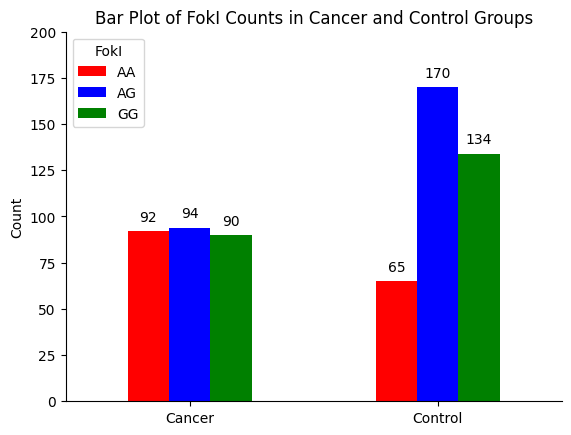

In [30]:
#@title Wykres częstości genotypów w grupach Cancer i Control

df_plot = fokI.groupby(['Grupa', 'FokI']).size()

# Assuming df_plot is a pandas Series
df_plot = df_plot.reset_index(name='Count')

# Pivot the DataFrame to have 'FokI' values as columns
df_plot_pivot = df_plot.pivot(index='Grupa', columns='FokI', values='Count')

# Plot the bar plot
ax = df_plot_pivot.plot(kind='bar', color=['red', 'blue', 'green'])

# Rotate x-axis tick labels to vertical position
ax.set_xticklabels(ax.get_xticklabels(), rotation=360)

# Set plot labels and title
ax.set_ylim(0,200)
ax.set_xlabel('').set_visible(False)
ax.set_ylabel('Count')
ax.set_title('Bar Plot of FokI Counts in Cancer and Control Groups')

# Add values over the bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Move the legend to the left top
ax.legend(title='FokI',loc='upper left', bbox_to_anchor=(0, 1), frameon=True)

# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()

Na powyższym wykresie wyraźnie widać, że genotypy w grupie *Cancer* są prawie równe sobie, a w grupie *Control* są one o wiele bardziej zróżnicowane. Widać również, że w grupie zdrowych osób o wiele więcej jest geneotypów AG oraz GG a mniej AA i liczebności są o wiele bardziej zróżnicowane. Na pierwszy rzut oka rycina pokazuje nam, że prawdopodbnie istnieją różnice pomiędzy liczebnościami genotypów w grupach. Należy jednak potwierdzić czy są to różnice istotne statystycznie, aby móc wyciągnąć wartościowe wnioski.

#### Test χ2

$H_0$: Brak różnic w częstościach występowania poszczególnych genotypów wariantu `FokI` pomiędzy grupami `Cancer` i `Control`. \\
$H_1$: Istnieją różnice w częstościach występowania poszczególnych genotypów wariantu `FokI` pomiędzy grupami `Cancer` i `Control`.

In [31]:
licz_chi2(fokI.groupby(['Grupa', 'FokI']).size())

Contingency Table
[[ 92  94  90]
 [ 65 170 134]]
################
Chi2 statistics: 22.21755
quantile: 5.99146
p-value: 1.4980299955502652e-05
H0 rejected


In [32]:
conti = pd.crosstab(fokI['Grupa'], fokI['FokI'])
chi, p, _, _ = chi2_contingency(conti)
print(f'p-value: {round(p,5)}', f'stat: {round(chi,5)}', sep='; ')

p-value: 1e-05; stat: 22.21755


Wartość statystyki testowej wynosi $22.22$. Otrzymane p-value na poziomie $1e^{-5}$ jest mniejsze od przyjętego poziomu istotności $(α = 0.05)$, dlatego istnieją podstawy do odrzucenia hipotezy zerowej. Występują różnice w częstościach występowania poszczególnych genotypów wariantu FokI pomiędzy grupami *Cancer* i *Control*.

### BsmI

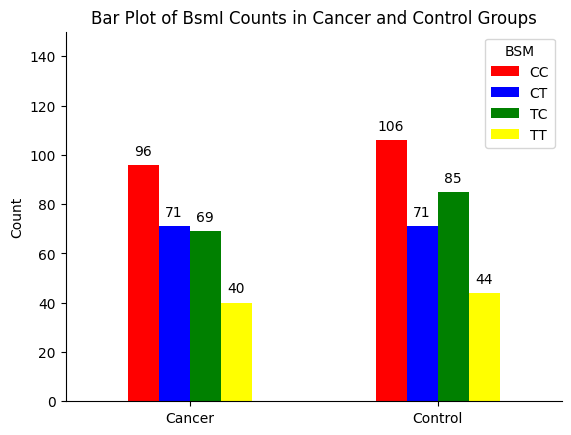

In [33]:
#@title Wykres częstości genotypów w grupach Cancer i Control

df_plot = bsm.groupby(['Grupa', 'BSM']).size()

# Assuming df_plot is a pandas Series
df_plot = df_plot.reset_index(name='Count')

# Pivot the DataFrame to have 'FokI' values as columns
df_plot_pivot = df_plot.pivot(index='Grupa', columns='BSM', values='Count')

# Plot the bar plot
ax = df_plot_pivot.plot(kind='bar', color=['red', 'blue', 'green', 'yellow'])

# Rotate x-axis tick labels to vertical position
ax.set_xticklabels(ax.get_xticklabels(), rotation=360)

# Set plot labels and title
ax.set_ylim(0,150)
ax.set_xlabel('').set_visible(False)
ax.set_ylabel('Count')
ax.set_title('Bar Plot of BsmI Counts in Cancer and Control Groups')

# Add values over the bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Move the legend to the left top
ax.legend(title='BSM',loc='upper right', frameon=True)

# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()

Na powyższym wykresie wyraźnie widać, że genotypy w grupie *Cancer* są różne względem siebie oprócz genotypów heterozygotycznych. W grupie *Control* są one o wiele bardziej zróżnicowane. Widać również, że w obu grupach przeważa ilości genotypów CC a mniej TT. Na pierwszy rzut oka rycina pokazuje nam, że prawdopodbnie nie ma różnic pomiędzy liczebnościami genotypów w grupach. Należy jednak potwierdzić, czy są to różnice istotne statystycznie, aby móc wyciągnąć wartościowe wnioski.

#### Test χ2

$H_0$: Brak różnic w częstościach występowania poszczególnych genotypów wariantu `BsmI` pomiędzy grupami `Cancer` i `Control`. \\
$H_1$: Istnieją różnice w częstościach występowania poszczególnych genotypów wariantu `BsmI` pomiędzy grupami `Cancer` i `Control`.

In [34]:
licz_chi2(bsm.groupby(['Grupa', 'BSM']).size())

Contingency Table
[[ 96  71  69  40]
 [106  71  85  44]]
################
Chi2 statistics: 0.80361
quantile: 7.81473
p-value: 0.8486041381706126
H0 not rejected


In [35]:
conti = pd.crosstab(bsm['Grupa'], bsm['BSM'])
chi, p, _, _ = chi2_contingency(conti)
print(f'p-value: {round(p,5)}', f'stat: {round(chi,5)}', sep='; ')

p-value: 0.8486; stat: 0.80361


Wartość statystyki testowej wynosi $0.80$. Otrzymane p-value na poziomie $0.85$ jest większe od przyjętego poziomu istotności $(α = 0.05)$, dlatego nie istnieją podstawy do odrzucenia hipotezy zerowej. Brak różnic w częstościach występowania poszczególnych genotypów wariantu BsmI pomiędzy grupami Cancer i Control.

## Odds Ratio Test

Ostatnim krokiem analizy było sprawdzenie, które z alleli częściej występują w genotypach wariantów FokI i BsmI.

### FokI

Tabela kontyngencji alleli wariantu FokI przedstawia się następująco:

<center>
<table>
<tr>
<th> </th>
<th>Cancer</th>
<th>Control</th>
</tr>
<tr>
  <td>A</td>
  <td><center>139</center></td>
  <td><center>150</center></td>
<tr>
<tr>
  <td>G</td>
  <td><center>137</center></td>
  <td><center>219</center></td>
<tr>
</table>
</center>

$H_0$: Allel A częściej występuje w genotypach wariantu `FokI` niż allel G. [OR > 1] \\
$H_1$: Allel A rzadziej występuje w genotypach wariantu `FokI` niż allel G [OR < 1]

In [36]:
oddsratio(fokI, 'FokI')

'Odds ratio: 1.35293'

Iloraz szans wynosi $1.35$ i przekracza wartość $1$. Na tej podstawie można wnioskować, że Allel A częściej występuje w genotypach wariantu FokI niż allel G.

### BsmI

Tabela kontyngencji alleli wariantu BsmI przedstawia się następująco:

<center>
<table>
<tr>
<th> </th>
<th>Cancer</th>
<th>Control</th>
</tr>
<tr>
  <td>C</td>
  <td><center>166</center></td>
  <td><center>184</center></td>
<tr>
<tr>
  <td>T</td>
  <td><center>139</center></td>
  <td><center>163</center></td>
<tr>
</table>
</center>

$H_0$: Allel C częściej występuje w genotypach wariantu `BsmI` niż allel T. [OR > 1] \\
$H_1$: Allel C rzadziej występuje w genotypach wariantu `BsmI` niż allel T [OR < 1]

In [37]:
oddsratio(bsm, 'BSM')

'Odds ratio: 0.79921'

Iloraz szans wynosi $0.80$ i nie przekracza wartości $1$. Na tej podstawie można wnioskować, że allel C rzadziej występuje w genotypach wariantu BsmI niż allel T.

# PODSUMOWANIE

W niniejszej pracy postawiono szereg hipotez dla rozkładu genotypów polimorfizmów genu VDR. Pierwsza z nich miała na celu sprawdzenie, czy częstości alleli i genotypów w populacji będą kształtować się zgodnie z przewidywaniami prawa Hardy'ego-Weinberga. W przypadku wariantu FokI zaobserwowano, że rozkład alleli w subpopulacji *Cancer* odbiega od rozkładu Hardy'ego-Weinberga, natomiast w *Control* tego samego wariantu, rozkład alleli jest zgodny z tymże prawem. W odniesieniu do wariantu BsmI, analiza statystyczna wykazała, że rozkład alleli zarówno w subpopulacji nowotworowej, jak i kontrolnej jest zgodny z rozkładem Hardy'ego-Weinberga, co sugeruje zachowaną równowagę genetyczną w obu grupach.

W Kolejnych krokach poddano testowaniu hipotezy dotyczące różnic w częstościach występowania poszczególnych genotypów w grupach. Wywnioskowano, że ma miejsce rozbieżność we frekwencjach występowania poszczególnych genotypów wariantu FokI pomiędzy grupami *Cancer* i *Control*, natomiast nie ma podstaw, aby przypuszczać taki sam stan rzeczy, jeśli chodzi o BsmI.

Korzystając z ilorazu szans otrzymano informacje, że Allel A częściej występuje w genotypach wariantu FokI niż allel G, a dla BsmI allel C występuje rzadziej niż T.

# LITERATURA

[1] Lisowska, K. A., & Bryl, E. (2017). Rola witaminy D w rozwoju chorób autoimmunologicznych. Postępy Higieny i Medycyny Doświadczalnej, 71, 797-810.

[2] Wysoczańska-Klaczyńska, A., Ślęzak, A., Hetman, M.,  & Barg, E. (2018). The impact of VDR gene polymorphisms on obesity, metabolic changes, bone mass disorders and neoplastic processes. Pediatric Endocrinology Diabetes and Metabolism, 24(2), 96-105.

[3] Małecki, M., Skupień, J., Waluś-Miarka, M., Owczarek, M., Czogała, M., Miarka, P., ... & Sieradzki, J. (2003). Polimorfizmy genu receptora witaminy D a ryzyko choroby niedokrwiennej serca w Polsce u chorych na cukrzycę typu 2 iu osób bez cukrzycy. Diabetologia Praktyczna, 4(2).